# 1.0 Library Imports

Below we import the libraries we will be using in this notebook.

Marker note, references will be made if code was taken from or inspired by a source. The references can be found in the report.

In [9]:
# Tensorflow imports.
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose

# OS import to access files.
import os

# Numpy Import for array normalizing.
import numpy as np

# skimage import for photo processing.
import skimage as ski
import sklearn as skl
from sklearn.model_selection import train_test_split

# matplot import for plotting.
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

# xmltodict import is used to parse the annotation file.
import xmltodict

# 2.0 Load Dataset with Annotations

Below we need to load in the dataset with the corresponding annotations. We will also be resizing the dataset to 512x512 images to ensure we have consistency for loading in the neural networks.

## 2.1 Define resize_points function

In [2]:
def resize_points(polygons, width, height):
    """
    Resizes polygon point coordinates to fit a 512x512 image resolution.
    
    Parameters:
        polygons (list of dict): A list of polygon annotations, each containing:
            - '@label' (str): The polygon's name (e.g., 'Post', 'Sign').
            - '@points' (str): A semicolon-separated string of x,y coordinates.
        width (int): The original image width.
        height (int): The original image height.
    
    Returns:
        dict: A dictionary with labels as keys ('Post', 'Sign', etc.) and their corresponding resized points as NumPy arrays. Missing labels are set to None.
    """
    # Create a container and set zero values for potential missing items.
    resized_polygons = {'Post': None,
                       'Sign': None,
                       'Lower Plate': None,
                       'Top Plate': None}
    
    # Loop through each polygon.
    for polygon in polygons:
        # Run within a try block as some odd exporting polygons exist in the annotation file.
        try:
            # Create storage for the related points in this polygon.
            points = polygon['@points']
        
            # Get the image scale based on the x and y factors.
            scale_x = 512 / width
            scale_y = 512 / height
        
            # Parse the polygon points.
            points = points.split(';')
            # Split the points and convert to float format. Reference 22 helped with this task.
            points = np.array([list(map(float, point.split(','))) for point in points])
        
            # Scale the points to the new resolution.
            scaled_points = []
            for point in points:
                scaled_points.append([point[0] * scale_x, point[1] * scale_y])
        
            # Store the scaled points in the container.
            resized_polygons[polygon['@label']] = np.array(scaled_points)
        except:
            print('Invalid polygon provided', polygon, '\n')
    
    # Return stored points
    return resized_polygons

## 2.2 Define get_mask function

In [3]:
def get_mask(points):
    """
    Generates a binary mask from polygon points for a 512x512 image.

    Parameters:
        points (np.ndarray or None): An (N, 2) array of (x, y) coordinates defining a polygon. If None, returns None.

    Returns:
        np.ndarray or None: A 512x512 uint8 mask with the polygon area filled in white (255), or None if points are None.
    """
    # Return none if ppints is None.
    if points is None:
        return None

    # Create mask array.
    mask = np.zeros((512, 512), dtype = np.uint8)

    # Get mask based on points.
    # Code from reference 23.
    rr, cc = ski.draw.polygon(points[:, 1], points[:, 0], mask.shape)

    # Overlay mask with white pixels.
    mask[rr, cc] = 255

    # Return the mask
    return mask

## 2.3 Load and Resize the Images/Masks

Below we will load in the images, resize them and load in and reszie the associated masks. This essentially sets up the dataset for use in machine learning algorithms.

In [4]:
# Create a storage container.
dataset = {}

# Parse the XML file
# Code reference: [15]
with open("./object_detection/annotations.xml", "r") as f:
    # Import the annotations in a dictionary format.
    annotations = xmltodict.parse(f.read())
    
# Loop through every image object in the annotations and store the image.
for image in annotations["annotations"]["image"]:
    # Get image name.
    image_name = image["@name"]
    
    # Load the image with scikit learn.
    photo = ski.io.imread("./object_detection/annotated_images" + '/' + image_name)

    # Greyscale the photo to reduce the complexity of the training data. This could lower accuracy, but as the literature review indicates, it seems to be the industry standard.
    photo = ski.color.rgb2gray(photo)

    # Create a resized image (512x512) in the storage container.
    # We'll need to store the images in 512x512 to standardize them for the neural networks
    resized_image = ski.transform.resize(photo, (512, 512), anti_aliasing=True)

    # Resize and standardize the polygon points
    resized_points = resize_points(image['polygon'], photo.shape[1], photo.shape[0])

    # Get the masks for each polygon.
    post_mask = get_mask(resized_points['Post'])
    sign_mask = get_mask(resized_points['Sign'])
    lower_plate_mask = get_mask(resized_points['Lower Plate'])
    top_plate_mask = get_mask(resized_points['Top Plate'])
    
    # Store the resized image and all associated masks.
    dataset[image_name] = {'image': resized_image, 
                          'post_mask': post_mask,
                          'sign_mask': sign_mask,
                          'lower_plate_mask': lower_plate_mask,
                          'top_plate_mask': top_plate_mask}

Invalid polygon provided @label 

Invalid polygon provided @source 

Invalid polygon provided @occluded 

Invalid polygon provided @points 

Invalid polygon provided @z_order 

Invalid polygon provided @label 

Invalid polygon provided @source 

Invalid polygon provided @occluded 

Invalid polygon provided @points 

Invalid polygon provided @z_order 



## 2.4 Confirm Masks Conform to Resized Image

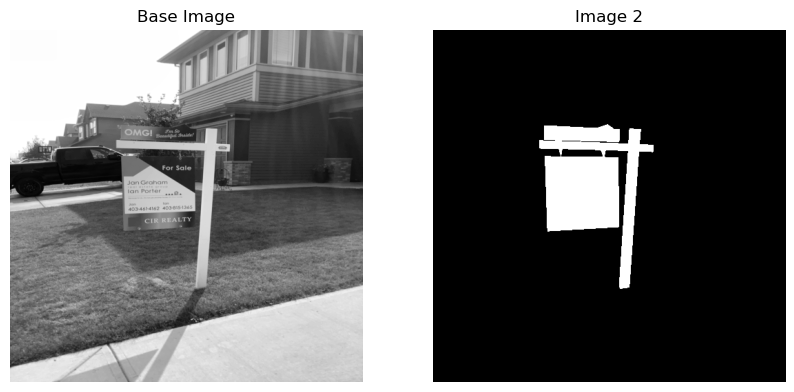

In [5]:
# Choose a random image
image_info = dataset['f_1723741777.jpg']

# Load photos.
photo = image_info['image']
photo_mask = photo.copy()

# Layer masks over photo.
mask = image_info['sign_mask'] + image_info['post_mask'] + image_info['top_plate_mask']

# Create plot.
fig, axes = plt.subplots(1, 2, figsize = (10, 5))

# Show base image
axes[0].imshow(photo, cmap='gray')
axes[0].set_title("Base Image")
axes[0].axis('off')

# Show image with mask.
axes[1].imshow(mask, cmap='gray')
axes[1].set_title("Image 2")
axes[1].axis('off')

# Show plot.
plt.show()

Above we can see the mask does align with the corresponding image and highlights the items we want to detect in a pixel-wise manner.

## 2.5 Convert Data into Tensors

In [15]:
def normalize(input_image):
    if input_image is None:
        return None
        
    # Normalize the pixel range values between [0:1]
    image = tf.cast(input_image, dtype = tf.float32) / 255.0
    return image

In [16]:
def normalize_dataset(dataset):
    normalized_dataset = {}
    for key, values in dataset.items():
        # Store the normalized data.
        normalized_dataset[key] = {'image': normalize(values['image']), 
                                  'post_mask': normalize(values['post_mask']),
                                  'sign_mask': normalize(values['sign_mask']),
                                  'lower_plate_mask': normalize(values['lower_plate_mask']),
                                  'top_plate_mask': normalize(values['top_plate_mask'])}

    return normalized_dataset

In [25]:
normalized_train_data = normalize_dataset(dataset)

# 3.0 Set up Base Model Architecture

Below we will set up the base model and run it individually on the different masks.
Most of the code below was heavily inspired or taken from reference 23.

In [10]:
train_length = len(normalized_train_data)
batch_size = 32
buffer_size = 1000
steps_per_epoch = train_length // batch_size
width = 512
height = 512

In [ ]:
train = dataset['train'].map(load_train_ds, num_parallel_calls=tf.data.AUTOTUNE)
 
train_ds = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test.batch(BATCH_SIZE)